# SUMMARY

##### Tuning Performance:
 - auc = 0.7587528763092081
 - accuracy = 0.7837009803921569
 - precision = 0.6272727272727273
 - recall = 0.3374083129584352
 - f1 = 0.43879173290938

##### Normal Performance:
 - auc = 0.8011032019787636
 - accuracy = 0.7827956989247312
 - precision = 0.6400911161731208
 - recall = 0.44745222929936307
 - f1 = 0.5267104029990628


# TUNING 

In [20]:
import numpy as np
# import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_data():
    # Fetch the data
    data_raw = pd.read_csv('dataset.csv')
    data_raw['Churn'].replace('No', 0, inplace=True)
    data_raw['Churn'].replace('Yes', 1, inplace=True)
    return data_raw

In [4]:
def preprocessing(data):
    # Seperate between categorical and numerical data
    clean_data_obj = data.select_dtypes(include=['object'])
    clean_data_num = data.select_dtypes(exclude=['object'])
    
    # One-hot categorical data
    clean_data_obj = pd.get_dummies(clean_data_obj,drop_first=True)

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(clean_data_num)
    clean_data_num = pd.DataFrame(scaler.transform(clean_data_num),columns=clean_data_num.keys())
    # Join back the data
    clean_data = clean_data_num.join(clean_data_obj)
    
    return clean_data

In [5]:
data_raw = load_data()

In [6]:
data_raw['TotalCharges'] = pd.to_numeric(data_raw['TotalCharges'], errors='coerce')
data_raw['TotalCharges'].loc[data_raw.isnull().any(axis=1)==True]

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64

In [7]:
data_raw['TotalCharges'].fillna(data_raw['TotalCharges'].mean(), inplace=True)

In [8]:
data_raw.columns[data_raw.isnull().any(axis=0)==True]

Index([], dtype='object')

### Outliers

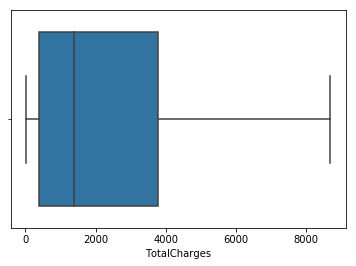

In [9]:
sns.boxplot(x=data_raw['TotalCharges'])

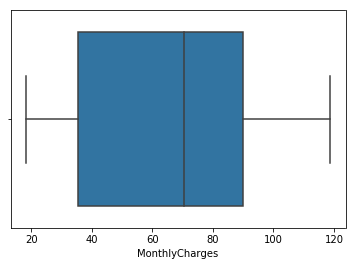

In [10]:
sns.boxplot(x=data_raw['MonthlyCharges'])

In [11]:
Q1 = data_raw.quantile(0.25)
Q3 = data_raw.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

SeniorCitizen        0.000
tenure              46.000
MonthlyCharges      54.350
TotalCharges      3384.375
Churn                1.000
dtype: float64


In [12]:
data_raw.shape

(7043, 21)

In [13]:
data_raw = data_raw[~((data_raw < (Q1 - 1.5 * IQR)) |(data_raw > (Q3 + 1.5 * IQR))).any(axis=1)]
data_raw.shape

(5901, 21)

### Feature selection

In [14]:
data_raw = data_raw.drop('customerID',axis=1)
data_raw = data_raw.drop('SeniorCitizen',axis=1)
prep_data = preprocessing(data_raw)

In [15]:
prep_data

tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  Partner_Yes  \
0     0.013889        0.115423      0.001275    0.0          0.0          1.0   
1     0.472222        0.385075      0.215867    0.0          1.0          0.0   
2     0.027778        0.354229      0.010310    1.0          1.0          0.0   
3     0.625000        0.239303      0.210241    0.0          1.0          0.0   
4     0.027778        0.521891      0.015330    1.0          0.0          0.0   
5     0.111111        0.809950      0.092511    1.0          0.0          0.0   
6     0.305556        0.704975      0.222779    0.0          1.0          0.0   
7     0.138889        0.114428      0.032668    0.0          0.0          0.0   
8     0.388889        0.861194      0.349325    1.0          0.0          1.0   
9     0.861111        0.377114      0.400317    0.0          1.0          0.0   
10    0.180556        0.315423      0.065619    0.0          1.0          1.0   
11    0.222222        0.006965      0.035541    0.0          1.0          0.0   
12    0.805556        0.816915      0.653393    0.0          1.0          1.0   
13    0.680556        0.850249      0.578987    1.0          1.0          0.0   
14    0.347222        0.868159      0.307783    0.0          1.0          0.0   
15    0.958333        0.945274      0.908880    0.0          0.0          1.0   
16    0.722222        0.023881      0.115872    0.0          0.0          0.0   
17    0.986111        0.880100      0.849694    0.0          1.0          0.0   
18    0.138889        0.367662      0.058799    1.0          0.0          1.0   
19    0.291667        0.714428      0.212797    0.0          0.0          0.0   
20    0.166667        0.015423      0.021169    0.0          NaN          NaN   
21    0.013889        0.018905      0.000156    1.0          1.0          1.0   
22    0.805556        0.414428      0.402296    0.0          1.0          0.0   
23    0.680556        0.411443      0.340584    0.0          0.0          1.0   
24    0.416667        0.368657      0.174452    0.0          1.0          1.0   
25    0.652778        0.806965      0.545852    1.0          0.0          0.0   
26    0.013889        0.118905      0.001315    1.0          1.0          1.0   
27    1.000000        0.716418      0.732824    0.0          1.0          1.0   
28    0.236111        0.462189      0.123967    1.0          1.0          1.0   
29    0.375000        0.476617      0.214130    0.0          0.0          0.0   
...        ...             ...           ...    ...          ...          ...   
5871  0.527778        0.764677      0.423771    0.0          1.0          0.0   
5872  0.319444        0.010448      0.053935    0.0          0.0          0.0   
5873  0.555556        0.858209      0.463657    1.0          0.0          0.0   
5874  0.319444        0.624378      0.219051    1.0          0.0          0.0   
5875  0.055556        0.419403      0.029235    1.0          0.0          1.0   
5876  0.861111        0.663682      0.592171    0.0          NaN          NaN   
5877  0.555556        0.747761      0.431295    0.0          0.0          0.0   
5878  0.569444        0.705970      0.418526    0.0          1.0          0.0   
5879  0.013889        0.315423      0.003595    0.0          1.0          1.0   
5880  0.708333        0.023881      0.115619    0.0          1.0          0.0   
5881  0.013889        0.521393      0.005983    1.0          0.0          0.0   
5882  0.541667        0.018905      0.093146    0.0          0.0          1.0   
5883  0.166667        0.009453      0.025410    0.0          0.0          0.0   
5884  0.166667        0.413433      0.081814    1.0          NaN          NaN   
5885  1.000000        0.862687      0.868394    0.0          1.0          1.0   
5886  0.611111        0.662189      0.416288    0.0          0.0          1.0   
5887  0.250000        0.764179      0.191622    0.0          1.0          0.0   
5888  0.125000        0.258209      0.0

### Correlation


In [16]:
prep_data['MonthlyCharges'].corr(prep_data['TotalCharges'])

0.661733192747925

In [17]:
# prep_data = prep_data.drop('InternetService_No',axis=1)
features = prep_data.dropna().drop('Churn',axis=1)
label = prep_data.dropna().Churn
train_x,test_x,train_y,test_y = train_test_split(features,label, test_size=0.33, random_state=42)

In [18]:
def eval_matrics(pred_class_y,pred_prob_y,label_y,model_name='Model'):
    # Matrics
    auc = roc_auc_score(label_y,pred_prob_y[:,1])
    acc = accuracy_score(label_y,pred_class_y)
    precision = precision_score(label_y,pred_class_y)
    recall = recall_score(label_y,pred_class_y)
    f1 = f1_score(label_y,pred_class_y)

    print("Performance:")
    print(" - auc = " + str(auc))
    print(" - accuracy = " + str(acc))
    print(" - precision = " + str(precision))
    print(" - recall = " + str(recall))
    print(" - f1 = " + str(f1))
    return    

In [21]:
# Fit and Predict
rf_clf = RandomForestClassifier().fit(train_x,train_y)
pred_class_y = rf_clf.predict(test_x)
pred_prob_y = rf_clf.predict_proba(test_x)
# Evaluate
eval_matrics(pred_class_y,pred_prob_y,test_y,'Random forrest Model')

Performance:
 - auc = 0.7587528763092081
 - accuracy = 0.7837009803921569
 - precision = 0.6272727272727273
 - recall = 0.3374083129584352
 - f1 = 0.43879173290938


# NOT TUNING 

In [22]:
data_raw = load_data()

In [23]:
data_raw['TotalCharges'] = pd.to_numeric(data_raw['TotalCharges'], errors='coerce')
data_raw['TotalCharges'].loc[data_raw.isnull().any(axis=1)==True]

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64

In [24]:
data_raw['TotalCharges'].fillna(data_raw['TotalCharges'].mean(), inplace=True)

In [25]:
data_raw.columns[data_raw.isnull().any(axis=0)==True]

Index([], dtype='object')

In [26]:
def preprocessing(data):
    # Seperate between categorical and numerical data
    clean_data_obj = data.select_dtypes(include=['object'])
    clean_data_num = data.select_dtypes(exclude=['object'])
    clean_data_obj['gender'].replace('Female', 0, inplace=True)
    clean_data_obj['gender'].replace('Male', 1, inplace=True)
    clean_data_obj['Partner'].replace('Yes', 1, inplace=True)
    clean_data_obj['Partner'].replace('No', 0, inplace=True)
    clean_data_obj['Dependents'].replace('Yes', 1, inplace=True)
    clean_data_obj['Dependents'].replace('No', 0, inplace=True)
    clean_data_obj['PhoneService'].replace('Yes', 1, inplace=True)
    clean_data_obj['PhoneService'].replace('No', 0, inplace=True)
    clean_data_obj['MultipleLines'].replace('Yes', 1, inplace=True)
    clean_data_obj['MultipleLines'].replace('No', 0, inplace=True)
    clean_data_obj['MultipleLines'].replace('No phone service', 2, inplace=True)
    
    clean_data_obj['InternetService'].replace('DSL', 1, inplace=True)
    clean_data_obj['InternetService'].replace('Fiber optic', 0, inplace=True)
    clean_data_obj['InternetService'].replace('No', 2, inplace=True)
    
    clean_data_obj['OnlineSecurity'].replace('Yes', 1, inplace=True)
    clean_data_obj['OnlineSecurity'].replace('No', 0, inplace=True)
    clean_data_obj['OnlineSecurity'].replace('No internet service', 2, inplace=True)
    
    clean_data_obj['OnlineBackup'].replace('Yes', 1, inplace=True)
    clean_data_obj['OnlineBackup'].replace('No', 0, inplace=True)
    clean_data_obj['OnlineBackup'].replace('No internet service', 2, inplace=True)
    
    clean_data_obj['DeviceProtection'].replace('Yes', 1, inplace=True)
    clean_data_obj['DeviceProtection'].replace('No', 0, inplace=True)
    clean_data_obj['DeviceProtection'].replace('No internet service', 2, inplace=True)
    
    clean_data_obj['TechSupport'].replace('Yes', 1, inplace=True)
    clean_data_obj['TechSupport'].replace('No', 0, inplace=True)
    clean_data_obj['TechSupport'].replace('No internet service', 2, inplace=True)
    
    clean_data_obj['StreamingTV'].replace('Yes', 1, inplace=True)
    clean_data_obj['StreamingTV'].replace('No', 0, inplace=True)
    clean_data_obj['StreamingTV'].replace('No internet service', 2, inplace=True)
    
    clean_data_obj['StreamingMovies'].replace('Yes', 1, inplace=True)
    clean_data_obj['StreamingMovies'].replace('No', 0, inplace=True)
    clean_data_obj['StreamingMovies'].replace('No internet service', 2, inplace=True)
    
    clean_data_obj['Contract'].replace('Month-to-month', 1, inplace=True)
    clean_data_obj['Contract'].replace('One year', 0, inplace=True)
    clean_data_obj['Contract'].replace('Two year', 2, inplace=True)
    
    clean_data_obj['PaperlessBilling'].replace('Yes', 1, inplace=True)
    clean_data_obj['PaperlessBilling'].replace('No', 0, inplace=True)
    
    clean_data_obj['PaymentMethod'].replace('Electronic check', 1, inplace=True)
    clean_data_obj['PaymentMethod'].replace('Mailed check', 0, inplace=True)
    clean_data_obj['PaymentMethod'].replace('Bank transfer (automatic)', 2, inplace=True)
    clean_data_obj['PaymentMethod'].replace('Credit card (automatic)', 3, inplace=True)
    
    clean_data = clean_data_num.join(clean_data_obj)
    
    return clean_data

In [27]:
data_raw = data_raw.drop('customerID',axis=1)

prep_data = preprocessing(data_raw)

In [28]:
prep_data

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender  \
0                 0       1           29.85         29.85      0       0   
1                 0      34           56.95       1889.50      0       1   
2                 0       2           53.85        108.15      1       1   
3                 0      45           42.30       1840.75      0       1   
4                 0       2           70.70        151.65      1       0   
5                 0       8           99.65        820.50      1       0   
6                 0      22           89.10       1949.40      0       1   
7                 0      10           29.75        301.90      0       0   
8                 0      28          104.80       3046.05      1       0   
9                 0      62           56.15       3487.95      0       1   
10                0      13           49.95        587.45      0       1   
11                0      16           18.95        326.80      0       1   
12                0      58          100.35       5681.10      0       1   
13                0      49          103.70       5036.30      1       1   
14                0      25          105.50       2686.05      0       1   
15                0      69          113.25       7895.15      0       0   
16                0      52           20.65       1022.95      0       0   
17                0      71          106.70       7382.25      0       1   
18                0      10           55.20        528.35      1       0   
19                0      21           90.05       1862.90      0       0   
20                1       1           39.65         39.65      1       1   
21                0      12           19.80        202.25      0       1   
22                0       1           20.15         20.15      1       1   
23                0      58           59.90       3505.10      0       0   
24                0      49           59.60       2970.30      0       1   
25                0      30           55.30       1530.60      0       0   
26                0      47           99.35       4749.15      1       1   
27                0       1           30.20         30.20      1       1   
28                0      72           90.25       6369.45      0       1   
29                0      17           64.70       1093.10      1       0   
...             ...     ...             ...           ...    ...     ...   
7013              0      40           93.40       3756.40      0       0   
7014              0      41           89.20       3645.75      0       1   
7015              1      34           85.20       2874.45      0       1   
7016              0       1           49.95         49.95      0       0   
7017              0      51           20.65       1020.75      0       0   
7018              0       1           70.65         70.65      1       1   
7019              0      39           20.15        826.00      0       0   
7020              0      12           19.20        239.00      0       1   
7021              0      12           59.80        727.80      1       1   
7022              0      72          104.95       7544.30      0       1   
7023              1      63          103.50       6479.40      0       0   
7024              0      44           84.80       3626.35      0       1   
7025              0      18           95.05       1679.40      0       0   
7026              0       9           44.20        403.35      1       0   
7027              0      13           73.35        931.55      0       1   
7028              0      68           64.10       4326.25      0       0   
7029              1       6           44.40        263.05      0       0   
7030              0       2           20.05         39.25      0       0   
7031              1      55           60.00       3316.10      0       1   
7032              1       1           75.75         75.75      1       1   
7033              0      38           69.50       2625

In [29]:
features = prep_data.dropna().drop('Churn',axis=1)
label = prep_data.dropna().Churn
train_x,test_x,train_y,test_y = train_test_split(features,label, test_size=0.33, random_state=42)

In [30]:
# Fit and Predict
rf_clf = RandomForestClassifier().fit(train_x,train_y)
pred_class_y = rf_clf.predict(test_x)
pred_prob_y = rf_clf.predict_proba(test_x)
# Evaluate
eval_matrics(pred_class_y,pred_prob_y,test_y,'Random forest Model')

Performance:
 - auc = 0.8011032019787636
 - accuracy = 0.7827956989247312
 - precision = 0.6400911161731208
 - recall = 0.44745222929936307
 - f1 = 0.5267104029990628
